# Introduction

In the second part of the assignment, we train a deep neural network (LSTM) for multi-class classification on the class corpus.

Text, that is, a sequence of words is a fundamentally different type of data when compared with tabular data or images/videos. For text neither is the input size fixed (e.g., movie reviews of different lengths) nor is the output fixed (e.g., binary classification or translated text). Deep learning with text is hence a case of variable inputs - variable outputs and needs special architectures (e.g., RNN's, Transformers).

The workflow to model text, however, remains the same - convert the documents to a vectorized representation and use this representation for a downstream task (e.g., sentiment analysis).

In [1]:
import pandas as pd
import tensorflow as tf

from pathlib import Path

# Data

Let us begin by preparing the data required to build the model.

In [2]:
data_file = '/content/DSP453_ClassCorpus_v1.csv'

In [3]:
class_corpus = pd.read_csv(data_file)

In [4]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    100 non-null    int64 
 1   DSI_Title                 100 non-null    object
 2   Text                      100 non-null    object
 3   Submission File Name      100 non-null    object
 4   Student Name              100 non-null    object
 5   Genre of Movie            100 non-null    object
 6   Review Type (pos or neg)  100 non-null    object
 7   Movie Title               100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB


# Sentiment Analysis

As an example of multi-class classification, let us look at building a deep neural network to infer the sentiment of a review from the text of the review. Along the way, we will look at the architecture of a recurrent neural network.

The [latest tensorflow API](https://www.tensorflow.org/tutorials/keras/text_classification) unifies dataset structures for text and images (see screenshot below). However, we do not have the data in this format. We will first bring our data to the format that is requried by Tensorflow. For large scale projects it is beneficial to use this format, since document level errors can be easily localized. 

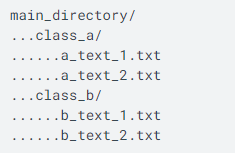

## Prepare Data

In [5]:
root_examples_dir = Path('/content/examples/')

In [6]:
root_examples_dir.mkdir(parents=True, exist_ok=True)

In [7]:
pos_examples_dir = root_examples_dir / 'positive'
neg_examples_dir = root_examples_dir / 'negative'

In [8]:
pos_examples_dir.mkdir(parents=True, exist_ok=True)
neg_examples_dir.mkdir(parents=True, exist_ok=True)

In [9]:
class_corpus_pos = class_corpus.loc[class_corpus["Review Type (pos or neg)"] == 'Positive', 'Text']
class_corpus_neg = class_corpus.loc[class_corpus["Review Type (pos or neg)"] == 'Negative', 'Text']

In [10]:
class_corpus_pos.shape, class_corpus_neg.shape

((50,), (50,))

In [11]:
for review_index, review in zip(class_corpus_pos.index, class_corpus_pos):
    with open(pos_examples_dir / (str(review_index) + ".txt"), "w") as f:
        f.write(review)

In [12]:
for review_index, review in zip(class_corpus_neg.index, class_corpus_neg):
    with open(neg_examples_dir / (str(review_index) + ".txt"), "w") as f:
        f.write(review)

In [13]:
len(list(pos_examples_dir.glob("*.txt"))), len(list(neg_examples_dir.glob("*.txt"))) 

(50, 50)

To create a text dataset from the corpus, we will need to specify the batch size.

In [14]:
BATCH_SIZE = 3

In [15]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(root_examples_dir, 
                                                          batch_size=BATCH_SIZE, 
                                                          validation_split=0.2, 
                                                          subset='training', 
                                                          seed=20130810)

Found 100 files belonging to 2 classes.
Using 80 files for training.


In [16]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Watching a Jordan Peele film is a uniquely unsettling experience. This is not just because \xc3\xaf\xc2\xbf\xc2\xbdGet Out,\xc3\xaf\xc2\xbf\xc2\xbd his brilliant debut, and now \xc3\xaf\xc2\xbf\xc2\xbdUs,\xc3\xaf\xc2\xbf\xc2\xbd are smart-and-scary horror movies. It is also because, after all the clues he dropped like so many breadcrumbs in \xc3\xaf\xc2\xbf\xc2\xbdGet Out,\xc3\xaf\xc2\xbf\xc2\xbd you cannot simply sit back and watch \xc3\xaf\xc2\xbf\xc2\xbdUs.\xc3\xaf\xc2\xbf\xc2\xbd You find yourself endlessly searching for hints, for tidbits, for the at-first-glance throwaway image that ultimately will unlock the secrets of the story. It\xc3\xaf\xc2\xbf\xc2\xbds relentless \xc3\xaf\xc2\xbf\xc2\xbd and it\xc3\xaf\xc2\xbf\xc2\xbds thrilling. Which is not to say that \xc3\xaf\xc2\xbf\xc2\xbdUs\xc3\xaf\xc2\xbf\xc2\xbd is the equal of \xc3\xaf\xc2\xbf\xc2\xbdGet Out.\xc3\xaf\xc2\xbf\xc2\xbd Few films are. But \xc3\xaf\xc2\xbf\xc2\xbdUs\xc3\xaf\xc2\xbf\xc2\xbd is a strong film in

In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to negative
Label 1 corresponds to positive


In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(root_examples_dir, 
                                                        batch_size=BATCH_SIZE, 
                                                        validation_split=0.2, 
                                                        subset='validation', 
                                                        seed=20130810)

Found 100 files belonging to 2 classes.
Using 20 files for validation.


[To speed up training](https://www.tensorflow.org/guide/data_performance), it is beneficial to shuffle, cache and prefetch the samples.

In [19]:
train_ds = (raw_train_ds.shuffle(buffer_size=raw_train_ds.cardinality().numpy())
                        .cache()
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

val_ds = (raw_val_ds.shuffle(buffer_size=raw_train_ds.cardinality().numpy())
                    .cache()
                    .prefetch(buffer_size=tf.data.AUTOTUNE))

## Vectorize

To vectorize the reviews, we use the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class. We can cap the vocabulary size to limit the tokens used for modeling to the most frequently appearing ones.

In [20]:
VOCAB_SIZE = 5000

In [21]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                            standardize="lower_and_strip_punctuation", 
                                            pad_to_max_tokens=True)

Note that beyond the default, we could change the `standardize` parameter to use a [custom function](https://www.tensorflow.org/tutorials/keras/text_classification).

In [22]:
encoder.adapt(train_ds.map(lambda text, label: text), 
              batch_size= None)

In [23]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,   63,  134, 1340,   55,    1,   64,   64])

In [24]:
print("1340: ", encoder.get_vocabulary()[1340])
print("1: ", encoder.get_vocabulary()[1])

print(f'Vocabulary size: {len(encoder.get_vocabulary())}')

1340:  talk
1:  [UNK]
Vocabulary size: 5000


Note how a special token `[UNK]` is used to identify out of vocabulary (OOV) words.

## Model

In [25]:
NUM_CLASSES = 2

As we have done so far, we make the encoder a part of the model. This ensures that the test data follows the patterns encoded during training (i.e., no data leakage).

The [LSTM cell](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) augments a vanilla RNN cell by incorporating among other things a gradient flow highway. If the LSTM cell is used as an intermediate layer, then it needs to return a sequence that is used by another downstream LSTM layer as an input (default is to return [the output of the last timestep](https://www.tensorflow.org/guide/keras/rnn)).

In [26]:
model = tf.keras.Sequential([# encoder generates one hot encoded corpus based on the vocabulary
                             encoder, 
                             # Embedding layer projects this vocabulary down to a smaller dimension
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 
                                                       64, 
                                                       mask_zero=True), 
                             # The first LSTM layer uses the outputs from the embedding layer
                             # as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  
                                                                                return_sequences=True, 
                                                                                dropout=0.3)),
                             # The second LSTM layer uses the outputs from the first LSTM
                             # layer as the input sequence
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                                                dropout=0.3)),
                             # The Dense layer uses outputs from the last time step of 
                             # the LSTM layer
                             tf.keras.layers.Dense(64, activation='relu'),
                             # The final layer outputs the 
                             tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  
])

Text is a special kind of a time-series where the context around the word in both directions encodes meaningful information. Hence, when working with text we use a [Bidirectional layer](https://www.tensorflow.org/guide/keras/rnn#bidirectional_rnns). The Bidirectional layer copies the LSTM layer and processes inputs in opposing orders as they run through the network. It then concatenates the forward layer output and backward layer output.


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [28]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                patience=5)])

Epoch 1/200
27/27 [==============================] - 29s 317ms/step - loss: 0.6931 - accuracy: 0.4500 - val_loss: 0.6926 - val_accuracy: 0.6000
Epoch 2/200
27/27 [==============================] - 4s 132ms/step - loss: 0.6930 - accuracy: 0.4500 - val_loss: 0.6926 - val_accuracy: 0.6000
Epoch 3/200
27/27 [==============================] - 3s 130ms/step - loss: 0.6931 - accuracy: 0.4875 - val_loss: 0.6926 - val_accuracy: 0.6000
Epoch 4/200
27/27 [==============================] - 3s 131ms/step - loss: 0.6927 - accuracy: 0.5750 - val_loss: 0.6926 - val_accuracy: 0.6000
Epoch 5/200
27/27 [==============================] - 4s 133ms/step - loss: 0.6925 - accuracy: 0.6125 - val_loss: 0.6926 - val_accuracy: 0.6000
Epoch 6/200
27/27 [==============================] - 4s 140ms/step - loss: 0.6927 - accuracy: 0.5750 - val_loss: 0.6926 - val_accuracy: 0.6000


# References

1. [Illustrated Guide to LSTM](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
2. [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)